In [1]:
import sys
sys.path.append('../..')
import multicomp as mm
import numpy as np

import os

os.getcwd()
sys.path

sys.path.append('/Users/calvinsmith/dufresne_lab/multicomponent-mixtures-main')

import multicomp.thermodynamics as td



# Generate Combinations(Calvin)

In [6]:
import numpy as np

def generate_combinations_2(num_components, step_size):
    
    combinations = []

    
    def generate(current, remaining, depth):
        if depth == num_components - 1:
            combinations.append(current + [remaining])
            return
        for i in np.arange(0, remaining + step_size, step_size):
            generate(current + [i], remaining - i, depth + 1)

    generate([], 1.0, 0)
    return np.array(combinations)


def replace_negative(matrix,small_val):
    # Replace negative values in the matrix with 0.01
    modified_matrix = np.where(matrix < 0, small_val, matrix)
    return modified_matrix




def thresh(arr, threshold):
    # Create a boolean mask where True indicates that all elements in the row are above the threshold
    mask = np.all(arr >= threshold, axis=1)

    # Use the mask to select rows that meet the condition
    return arr[mask]


In [33]:

#Generate combinations with (num_comp, step_size)
#Threshold function, gets rid of all rows with values less than threshold

combinations = generate_combinations_2(3,0.02)
combinations = thresh(combinations,0.01)
print(combinations)

len(combinations)

#combinations = np.array([row for row in combinations if 0 not in row])
#combinations -= 0.01
#combinations = replace_negative(combinations,0.01)
#print(combinations)


[[0.02 0.02 0.96]
 [0.02 0.04 0.94]
 [0.02 0.06 0.92]
 ...
 [0.94 0.02 0.04]
 [0.94 0.04 0.02]
 [0.96 0.02 0.02]]


1176

# Obtain coexisting phases for an arbitrary interaction matrix and average compositions
Note: package assumes the existence of an inert solvent, determined by the incompressibility condition.

## system settings

In [34]:
# an arbitrary symmetric matrix of 4 components + 1 inert solvent.
# The interaction between components and the solvent is assume to be zero.
# Note that the diagonal elements are not necessary to be zero.
# With non-zero diagonal elements, the system will be effective interactions between solvent and other components.
'''chi_matrix = [
    [0.0, 4.0, 5.0, 6.0],
    [4.0, 0.0, 7.0, 6.0],
    [5.0, 7.0, 0.0, 3.0],
    [6.0, 6.0, 3.0, 0.0],
]'''


chi_matrix = np.array([[0, 2.7, 2.8], [0, 0, 2.9], [0, 0, 0]])
chi_matrix = chi_matrix + chi_matrix.T

# average compositions of the entire system
# the volume fraction of the solvent is determined by incompressibility
phi_vector = [0.33, 0.33, 0.33]

## Create some compartments

In [35]:
# number of phases that the system will generate
num_compartments = 64 # a overkill but safe choice for 4+1 components
# create the Flory-Huggins free energy
fh_energy = mm.FloryHuggins(np.array(chi_matrix))
# generate a collection of compartments
# we generate compartments that all of them share the same composition, namely the average composition, here.
# the FieldLikeRelaxationDynamics afterwards will add fluctuations to the compositions itself.


phis = [phi_vector] * num_compartments
mixture = mm.MultiphaseVolumeSystem(
    fh_energy, 
    np.array(phis), # compositions of each compartment
    np.ones(num_compartments) / num_compartments # relative volume of each compartment
)

## Hyperparameters 

In [36]:
dynamics_params = {
    "initialization_random_std": 5,  # how random the initial guess is
    "acceptance_Js": 0.0002, # how fast the relative volumes are evolved
    "acceptance_omega": 0.002, # how fast the compositions are evolved
}

evolve_params = {
    "t_range": 1000000,  # maximum iteration steps
    "dt": 1,  # always unity for FieldLikeRelaxationDynamics
    "interval": 10000,  # the frequency for checking convergence
    "tolerance": 1e-5,  # criteria for determining convergence
    "progress": True,
    "save_intermediate_data": False,
}

## Create the dynamics and find the coexisting states

In [37]:
dynamics = mm.FieldLikeRelaxationDynamics(mixture, parameters=dynamics_params)
ts, result = dynamics.evolve(**evolve_params)

## Print and Check

In [39]:
unique_phases = result.get_clusters()
print(len(unique_phases), "phases are found")
print("Compositions are ")
print(unique_phases)
print("Convergence is (lower the better) ")
print(result.entropy_production)



3 phases are found
Compositions are 
[[0.14237373 0.13019    0.71852936]
 [0.18306244 0.65540908 0.15185324]
 [0.54339876 0.23481733 0.21089615]]
Convergence is (lower the better) 
0.0005260572793473427


# Test Functions

In [40]:
def get_no_of_phases(phi_vector,fh_energy):
    dynamics_params = {
    "initialization_random_std": 5,  # how random the initial guess is
    "acceptance_Js": 0.0002, # how fast the relative volumes are evolved
    "acceptance_omega": 0.002, # how fast the compositions are evolved
    }

    evolve_params = {
    "t_range": 1000000,  # maximum iteration steps
    "dt": 1,  # always unity for FieldLikeRelaxationDynamics
    "interval": 10000,  # the frequency for checking convergence
    "tolerance": 1e-5,  # criteria for determining convergence
    "progress": True,
    "save_intermediate_data": False,
    }
    
    num_compartments = 64
    
    phis = [phi_vector] * num_compartments
    #This is David's new Evolutionary Algorithm
    mixture = mm.MultiphaseVolumeSystem(
        fh_energy, 
        np.array(phis), # compositions of each compartment
        np.ones(num_compartments) / num_compartments # relative volume of each compartment
    )    
    
    dynamics = mm.FieldLikeRelaxationDynamics(mixture, parameters=dynamics_params)
    ts, result = dynamics.evolve(**evolve_params)
    unique_phases = result.get_clusters()
    return len(unique_phases)
    
    


In [41]:
get_no_of_phases(phi_vector,fh_energy)


3

In [42]:
from tqdm.notebook import tqdm
print("start")
'''
combinations = generate_combinations_2(3,0.1)
combinations = np.array([row for row in combinations if 0 not in row])

combinations -= 0.01
combinations = replace_negative(combinations,0.01)
'''
ternary_matrix = np.empty((combinations.shape[0], 2), dtype=object)
#print(combinations)

print("Init ternary_matrix")


for i, row in enumerate(tqdm(combinations)):
    print("row " + str(i))
    ternary_matrix[i, 0] = row
   
    # Apply the arbitrary function to the row and add the result to the second column
    fh_energy = mm.FloryHuggins(np.array(chi_matrix))
    ternary_matrix[i, 1] = get_no_of_phases(row,fh_energy)
    print(ternary_matrix[i,1])

    


start
Init ternary_matrix


row 0



1
row 1



1
row 2



1
row 3



1
row 4



2
row 5



2
row 6



2
row 7



2
row 8



2
row 9



2
row 10



2
row 11



2
row 12



2
row 13



2
row 14



2
row 15



2
row 16



2
row 17



2
row 18



2
row 19



2
row 20



2
row 21



2
row 22



2
row 23



2
row 24



2
row 25



2
row 26



2
row 27



2
row 28



2
row 29



2
row 30



2
row 31



2
row 32



2
row 33



2
row 34



2
row 35



2
row 36



2
row 37



2
row 38



2
row 39



2
row 40



2
row 41



2
row 42



2
row 43



2
row 44



1
row 45



1
row 46



1
row 47



1
row 48



1
row 49



1
row 50



1
row 51



1
row 52



2
row 53



2
row 54



2
row 55



2
row 56



2
row 57



2
row 58



2
row 59



2
row 60



2
row 61



2
row 62



2
row 63



2
row 64



2
row 65



2
row 66



2
row 67



2
row 68



2
row 69



2
row 70



2
row 71



2
row 72



2
row 73



2
row 74



2
row 75



2
row 76



2
row 77



2
row 78



2
row 79



2
row 80



2
row 81



2
row 82



2
row 83



2
row 84



2
row 85



2
row 86



2
row 87



2
row 88



2
row 89



2
row 90



2
row 91



1
row 92



1
row 93



1
row 94



1
row 95



1
row 96



1
row 97



1
row 98



1
row 99



2
row 100



2
row 101



2
row 102



2
row 103



2
row 104



2
row 105



2
row 106



2
row 107



2
row 108



2
row 109



2
row 110



2
row 111



2
row 112



2
row 113



2
row 114



2
row 115



2
row 116



2
row 117



2
row 118



2
row 119



2
row 120



2
row 121



2
row 122



2
row 123



2
row 124



2
row 125



2
row 126



2
row 127



2
row 128



2
row 129



2
row 130



2
row 131



2
row 132



2
row 133



2
row 134



2
row 135



2
row 136



2
row 137



1
row 138



1
row 139



1
row 140



1
row 141



1
row 142



1
row 143



1
row 144



1
row 145



1
row 146



2
row 147



2
row 148



2
row 149



2
row 150



2
row 151



2
row 152



2
row 153



2
row 154



2
row 155



2
row 156



2
row 157



2
row 158



2
row 159



2
row 160



2
row 161



2
row 162



2
row 163



2
row 164



2
row 165



2
row 166



2
row 167



2
row 168



2
row 169



2
row 170



2
row 171



2
row 172



2
row 173



2
row 174



2
row 175



2
row 176



2
row 177



2
row 178



2
row 179



2
row 180



2
row 181



1
row 182



1
row 183



1
row 184



1
row 185



1
row 186



2
row 187



1
row 188



1
row 189



1
row 190



1
row 191



2
row 192



2
row 193



2
row 194



2
row 195



2
row 196



2
row 197



2
row 198



2
row 199



2
row 200



2
row 201



2
row 202



2
row 203



2
row 204



2
row 205



2
row 206



2
row 207



2
row 208



2
row 209



2
row 210



2
row 211



2
row 212



2
row 213



2
row 214



2
row 215



2
row 216



2
row 217



2
row 218



2
row 219



2
row 220



2
row 221



2
row 222



2
row 223



2
row 224



2
row 225



1
row 226



1
row 227



1
row 228



1
row 229



1
row 230



2
row 231



2
row 232



2
row 233



2
row 234



1
row 235



2
row 236



2
row 237



2
row 238



2
row 239



2
row 240



2
row 241



2
row 242



2
row 243



2
row 244



2
row 245



2
row 246



2
row 247



2
row 248



2
row 249



2
row 250



2
row 251



2
row 252



2
row 253



2
row 254



2
row 255



2
row 256



2
row 257



2
row 258



2
row 259



2
row 260



2
row 261



2
row 262



2
row 263



2
row 264



2
row 265



2
row 266



2
row 267



2
row 268



1
row 269



1
row 270



1
row 271



1
row 272



2
row 273



2
row 274



2
row 275



2
row 276



2
row 277



2
row 278



2
row 279



4
row 280



3
row 281



2
row 282



4
row 283



3
row 284



3
row 285



3
row 286



2
row 287



2
row 288



2
row 289



2
row 290



2
row 291



2
row 292



2
row 293



2
row 294



2
row 295



2
row 296



2
row 297



2
row 298



2
row 299



2
row 300



2
row 301



2
row 302



2
row 303



2
row 304



2
row 305



2
row 306



2
row 307



2
row 308



2
row 309



1
row 310



1
row 311



2
row 312



2
row 313



2
row 314



2
row 315



2
row 316



2
row 317



2
row 318



2
row 319



2
row 320



2
row 321



3
row 322



3
row 323



3
row 324



3
row 325



3
row 326



3
row 327



3
row 328



3
row 329



3
row 330



3
row 331



3
row 332



4
row 333



3
row 334



3
row 335



4
row 336



3
row 337



3
row 338



3
row 339



3
row 340



3
row 341



2
row 342



3
row 343



2
row 344



3
row 345



2
row 346



3
row 347



3
row 348



3
row 349



2
row 350



2
row 351



2
row 352



2
row 353



2
row 354



2
row 355



2
row 356



2
row 357



2
row 358



2
row 359



2
row 360



2
row 361



2
row 362



3
row 363



3
row 364



3
row 365



3
row 366



3
row 367



3
row 368



3
row 369



3
row 370



3
row 371



3
row 372



3
row 373



3
row 374



3
row 375



3
row 376



3
row 377



3
row 378



3
row 379



3
row 380



3
row 381



3
row 382



3
row 383



3
row 384



3
row 385



3
row 386



3
row 387



3
row 388



3
row 389



2
row 390



2
row 391



2
row 392



2
row 393



2
row 394



2
row 395



2
row 396



2
row 397



2
row 398



2
row 399



2
row 400



2
row 401



2
row 402



2
row 403



3
row 404



3
row 405



3
row 406



3
row 407



3
row 408



3
row 409



3
row 410



3
row 411



3
row 412



3
row 413



3
row 414



3
row 415



3
row 416



3
row 417



3
row 418



3
row 419



3
row 420



3
row 421



3
row 422



3
row 423



3
row 424



3
row 425



3
row 426



3
row 427



4
row 428



2
row 429



2
row 430



2
row 431



2
row 432



2
row 433



2
row 434



2
row 435



2
row 436



2
row 437



2
row 438



2
row 439



2
row 440



2
row 441



2
row 442



3
row 443



3
row 444



3
row 445



3
row 446



3
row 447



3
row 448



3
row 449



3
row 450



3
row 451



3
row 452



3
row 453



3
row 454



3
row 455



3
row 456



3
row 457



3
row 458



3
row 459



3
row 460



3
row 461



3
row 462



3
row 463



3
row 464



3
row 465



3
row 466



2
row 467



2
row 468



2
row 469



2
row 470



2
row 471



2
row 472



2
row 473



2
row 474



2
row 475



2
row 476



2
row 477



2
row 478



2
row 479



2
row 480



4
row 481



3
row 482



3
row 483



3
row 484



3
row 485



3
row 486



3
row 487



3
row 488



3
row 489



3
row 490



3
row 491



3
row 492



3
row 493



3
row 494



3
row 495



3
row 496



3
row 497



3
row 498



3
row 499



3
row 500



3
row 501



3
row 502



3
row 503



2
row 504



2
row 505



2
row 506



2
row 507



2
row 508



2
row 509



2
row 510



2
row 511



2
row 512



2
row 513



2
row 514



2
row 515



2
row 516



2
row 517



3
row 518



3
row 519



3
row 520



3
row 521



3
row 522



3
row 523



3
row 524



3
row 525



3
row 526



3
row 527



3
row 528



3
row 529



3
row 530



3
row 531



3
row 532



3
row 533



3
row 534



3
row 535



3
row 536



3
row 537



3
row 538



3
row 539



2
row 540



2
row 541



2
row 542



2
row 543



2
row 544



2
row 545



2
row 546



2
row 547



2
row 548



2
row 549



2
row 550



2
row 551



2
row 552



2
row 553



3
row 554



3
row 555



3
row 556



3
row 557



3
row 558



3
row 559



3
row 560



3
row 561



3
row 562



3
row 563



3
row 564



3
row 565



3
row 566



3
row 567



3
row 568



3
row 569



3
row 570



3
row 571



3
row 572



3
row 573



3
row 574



2
row 575



2
row 576



2
row 577



2
row 578



2
row 579



2
row 580



2
row 581



2
row 582



2
row 583



2
row 584



2
row 585



2
row 586



2
row 587



2
row 588



3
row 589



3
row 590



3
row 591



3
row 592



3
row 593



3
row 594



3
row 595



3
row 596



3
row 597



3
row 598



3
row 599



3
row 600



3
row 601



3
row 602



3
row 603



3
row 604



3
row 605



3
row 606



3
row 607



3
row 608



2
row 609



2
row 610



2
row 611



2
row 612



2
row 613



2
row 614



2
row 615



2
row 616



2
row 617



2
row 618



2
row 619



2
row 620



2
row 621



2
row 622



2
row 623



3
row 624



3
row 625



3
row 626



3
row 627



3
row 628



3
row 629



3
row 630



3
row 631



3
row 632



3
row 633



3
row 634



3
row 635



3
row 636



3
row 637



3
row 638



3
row 639



3
row 640



3
row 641



2
row 642



2
row 643



2
row 644



2
row 645



2
row 646



2
row 647



2
row 648



2
row 649



2
row 650



2
row 651



2
row 652



2
row 653



2
row 654



2
row 655



2
row 656



3
row 657



3
row 658



3
row 659



3
row 660



3
row 661



3
row 662



3
row 663



3
row 664



3
row 665



3
row 666



3
row 667



3
row 668



3
row 669



3
row 670



3
row 671



3
row 672



2
row 673



2
row 674



2
row 675



2
row 676



2
row 677



2
row 678



2
row 679



2
row 680



2
row 681



2
row 682



2
row 683



2
row 684



2
row 685



2
row 686



2
row 687



2
row 688



3
row 689



3
row 690



3
row 691



3
row 692



3
row 693



3
row 694



3
row 695



3
row 696



3
row 697



3
row 698



3
row 699



3
row 700



3
row 701



3
row 702



3
row 703



2
row 704



2
row 705



2
row 706



2
row 707



2
row 708



2
row 709



2
row 710



2
row 711



2
row 712



2
row 713



2
row 714



2
row 715



2
row 716



2
row 717



2
row 718



2
row 719



3
row 720



3
row 721



3
row 722



3
row 723



3
row 724



3
row 725



3
row 726



3
row 727



3
row 728



3
row 729



3
row 730



3
row 731



3
row 732



3
row 733



2
row 734



2
row 735



2
row 736



2
row 737



2
row 738



2
row 739



2
row 740



2
row 741



2
row 742



2
row 743



2
row 744



2
row 745



2
row 746



2
row 747



2
row 748



2
row 749



3
row 750



3
row 751



3
row 752



3
row 753



3
row 754



3
row 755



3
row 756



3
row 757



3
row 758



3
row 759



3
row 760



3
row 761



3
row 762



2
row 763



2
row 764



2
row 765



2
row 766



2
row 767



2
row 768



2
row 769



2
row 770



2
row 771



2
row 772



2
row 773



2
row 774



2
row 775



2
row 776



2
row 777



2
row 778



3
row 779



3
row 780



3
row 781



3
row 782



3
row 783



3
row 784



3
row 785



3
row 786



3
row 787



3
row 788



3
row 789



3
row 790



3
row 791



2
row 792



2
row 793



2
row 794



2
row 795



2
row 796



2
row 797



2
row 798



2
row 799



2
row 800



2
row 801



2
row 802



2
row 803



2
row 804



2
row 805



2
row 806



3
row 807



3
row 808



3
row 809



3
row 810



3
row 811



3
row 812



3
row 813



3
row 814



3
row 815



3
row 816



3
row 817



2
row 818



2
row 819



2
row 820



2
row 821



2
row 822



2
row 823



2
row 824



2
row 825



2
row 826



2
row 827



2
row 828



2
row 829



2
row 830



2
row 831



2
row 832



2
row 833



3
row 834



3
row 835



3
row 836



3
row 837



3
row 838



3
row 839



3
row 840



3
row 841



3
row 842



3
row 843



2
row 844



2
row 845



2
row 846



2
row 847



2
row 848



2
row 849



2
row 850



2
row 851



2
row 852



2
row 853



2
row 854



2
row 855



2
row 856



2
row 857



2
row 858



2
row 859



3
row 860



3
row 861



3
row 862



3
row 863



3
row 864



3
row 865



3
row 866



3
row 867



3
row 868



2
row 869



2
row 870



2
row 871



2
row 872



2
row 873



2
row 874



2
row 875



2
row 876



2
row 877



2
row 878



2
row 879



2
row 880



2
row 881



2
row 882



2
row 883



2
row 884



2
row 885



3
row 886



3
row 887



3
row 888



3
row 889



3
row 890



3
row 891



3
row 892



2
row 893



2
row 894



2
row 895



2
row 896



2
row 897



2
row 898



2
row 899



2
row 900



2
row 901



2
row 902



2
row 903



2
row 904



2
row 905



2
row 906



2
row 907



2
row 908



2
row 909



3
row 910



3
row 911



3
row 912



3
row 913



3
row 914



3
row 915



2
row 916



2
row 917



2
row 918



2
row 919



2
row 920



2
row 921



2
row 922



2
row 923



2
row 924



2
row 925



2
row 926



2
row 927



2
row 928



2
row 929



2
row 930



2
row 931



2
row 932



3
row 933



3
row 934



3
row 935



3
row 936



3
row 937



2
row 938



2
row 939



2
row 940



2
row 941



2
row 942



2
row 943



2
row 944



2
row 945



2
row 946



2
row 947



2
row 948



2
row 949



2
row 950



2
row 951



2
row 952



2
row 953



3
row 954



3
row 955



3
row 956



3
row 957



3
row 958



2
row 959



2
row 960



2
row 961



2
row 962



2
row 963



2
row 964



2
row 965



2
row 966



2
row 967



2
row 968



2
row 969



2
row 970



2
row 971



2
row 972



2
row 973



2
row 974



3
row 975



3
row 976



3
row 977



3
row 978



2
row 979



2
row 980



2
row 981



2
row 982



2
row 983



2
row 984



2
row 985



2
row 986



2
row 987



2
row 988



2
row 989



2
row 990



2
row 991



2
row 992



2
row 993



2
row 994



2
row 995



3
row 996



3
row 997



2
row 998



2
row 999



2
row 1000



2
row 1001



2
row 1002



2
row 1003



2
row 1004



2
row 1005



2
row 1006



2
row 1007



2
row 1008



2
row 1009



2
row 1010



2
row 1011



2
row 1012



2
row 1013



3
row 1014



4
row 1015



2
row 1016



2
row 1017



2
row 1018



2
row 1019



2
row 1020



2
row 1021



2
row 1022



2
row 1023



2
row 1024



2
row 1025



2
row 1026



2
row 1027



2
row 1028



2
row 1029



2
row 1030



2
row 1031



2
row 1032



2
row 1033



2
row 1034



2
row 1035



2
row 1036



2
row 1037



2
row 1038



2
row 1039



2
row 1040



2
row 1041



2
row 1042



2
row 1043



2
row 1044



2
row 1045



2
row 1046



2
row 1047



2
row 1048



1
row 1049



2
row 1050



2
row 1051



2
row 1052



2
row 1053



2
row 1054



2
row 1055



2
row 1056



2
row 1057



2
row 1058



2
row 1059



2
row 1060



2
row 1061



2
row 1062



2
row 1063



2
row 1064



2
row 1065



2
row 1066



2
row 1067



2
row 1068



2
row 1069



2
row 1070



2
row 1071



2
row 1072



2
row 1073



2
row 1074



2
row 1075



2
row 1076



2
row 1077



2
row 1078



1
row 1079



2
row 1080



2
row 1081



2
row 1082



2
row 1083



2
row 1084



2
row 1085



2
row 1086



2
row 1087



2
row 1088



2
row 1089



2
row 1090



2
row 1091



1
row 1092



2
row 1093



2
row 1094



2
row 1095



2
row 1096



2
row 1097



2
row 1098



2
row 1099



2
row 1100



2
row 1101



2
row 1102



2
row 1103



2
row 1104



1
row 1105



2
row 1106



2
row 1107



2
row 1108



2
row 1109



2
row 1110



2
row 1111



2
row 1112



2
row 1113



2
row 1114



2
row 1115



1
row 1116



1
row 1117



2
row 1118



2
row 1119



2
row 1120



2
row 1121



2
row 1122



2
row 1123



2
row 1124



2
row 1125



1
row 1126



1
row 1127



2
row 1128



2
row 1129



2
row 1130



2
row 1131



2
row 1132



2
row 1133



2
row 1134



2
row 1135



1
row 1136



1
row 1137



2
row 1138



2
row 1139



2
row 1140



2
row 1141



2
row 1142



2
row 1143



1
row 1144



1
row 1145



1
row 1146



2
row 1147



2
row 1148



2
row 1149



2
row 1150



1
row 1151



1
row 1152



1
row 1153



1
row 1154



2
row 1155



2
row 1156



1
row 1157



1
row 1158



1
row 1159



1
row 1160



2
row 1161



2
row 1162



1
row 1163



1
row 1164



1
row 1165



1
row 1166



1
row 1167



1
row 1168



1
row 1169



1
row 1170



1
row 1171



1
row 1172



1
row 1173



1
row 1174



1
row 1175



1



# Plot Ternary Diagram

In [43]:
import matplotlib.pyplot as plt
import mpltern  # Import the mpltern package for ternary plots
def plot_ternary(data):

    ternary_components = np.array([item[0].flatten() for item in data])
    values = np.array([item[1] for item in data])

    # Create ternary plot
    fig, tax = plt.subplots(subplot_kw=dict(projection='ternary'))

    # Scatter plot where color depends on the value
    sc = tax.scatter(ternary_components[:, 0], ternary_components[:, 1], ternary_components[:, 2], c=values, cmap='viridis')

    # Add color bar
    plt.colorbar(sc, label='Value')

    # Setting labels for ternary axes
    tax.set_tlabel("Component 1")
    tax.set_llabel("Component 2")
    tax.set_rlabel("Component 3")

    # Set title and other plot labels if necessary
    plt.title("Ternary Phase Diagram")

    plt.show()




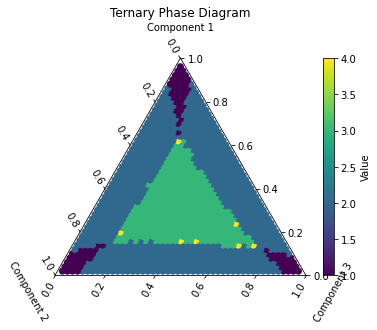

[[array([0.02, 0.02, 0.96]) 1]
 [array([0.02, 0.04, 0.94]) 1]
 [array([0.02, 0.06, 0.92]) 1]
 ...
 [array([0.94, 0.02, 0.04]) 1]
 [array([0.94, 0.04, 0.02]) 1]
 [array([0.96, 0.02, 0.02]) 1]]


In [44]:
plot_ternary(ternary_matrix)
print(ternary_matrix)

In [50]:
flattened_data = np.array([np.append(subarray, value) for subarray, value in ternary_matrix])
# Absolute path where the CSV file will be saved
name = 'ternary_0.02_chi_Convex_hull.csv'
save_path = '/Users/calvinsmith/dufresne_lab/data/' + name  # Change this to your desired path

# Save to CSV
np.savetxt(save_path, flattened_data, delimiter=",", fmt='%g')
print('done')

done


In [45]:
from tqdm.notebook import tqdm
print("start")
'''
combinations = generate_combinations_2(3,0.1)
combinations = np.array([row for row in combinations if 0 not in row])

combinations -= 0.01
combinations = replace_negative(combinations,0.01)
'''
ternary_matrix_2 = np.empty((combinations.shape[0], 2), dtype=object)
#print(combinations)

print("Init ternary_matrix")


chi_matrix = np.array([[0, 1.5, 2.7], [0, 0, 3.2], [0, 0, 0]])
chi_matrix = chi_matrix + chi_matrix.T


for i, row in enumerate(tqdm(combinations)):
    print("row " + str(i))
    ternary_matrix_2[i, 0] = row
   
    # Apply the arbitrary function to the row and add the result to the second column
    fh_energy = mm.FloryHuggins(np.array(chi_matrix))
    ternary_matrix_2[i, 1] = get_no_of_phases(row,fh_energy)
    print(ternary_matrix_2[i,1])

    


start
Init ternary_matrix


row 0



1
row 1



1
row 2



2
row 3



2
row 4



2
row 5



2
row 6



2
row 7



2
row 8



2
row 9



2
row 10



2
row 11



2
row 12



2
row 13



2
row 14



2
row 15



2
row 16



2
row 17



2
row 18



2
row 19



2
row 20



2
row 21



2
row 22



2
row 23



2
row 24



2
row 25



2
row 26



2
row 27



2
row 28



2
row 29



2
row 30



2
row 31



2
row 32



2
row 33



2
row 34



2
row 35



2
row 36



2
row 37



2
row 38



2
row 39



2
row 40



2
row 41



2
row 42



2
row 43



2
row 44



2
row 45



2
row 46



1
row 47



1
row 48



1
row 49



1
row 50



2
row 51



2
row 52



2
row 53



2
row 54



2
row 55



2
row 56



2
row 57



2
row 58



2
row 59



2
row 60



2
row 61



2
row 62



2
row 63



2
row 64



2
row 65



2
row 66



2
row 67



2
row 68



2
row 69



2
row 70



2
row 71



2
row 72



2
row 73



2
row 74



2
row 75



2
row 76



2
row 77



2
row 78



2
row 79



2
row 80



2
row 81



2
row 82



2
row 83



2
row 84



2
row 85



2
row 86



2
row 87



2
row 88



2
row 89



2
row 90



2
row 91



2
row 92



1
row 93



1
row 94



1
row 95



1
row 96



1
row 97



2
row 98



2
row 99



2
row 100



2
row 101



2
row 102



2
row 103



2
row 104



2
row 105



2
row 106



2
row 107



2
row 108



2
row 109



2
row 110



2
row 111



2
row 112



2
row 113



2
row 114



2
row 115



2
row 116



2
row 117



2
row 118



2
row 119



2
row 120



2
row 121



2
row 122



2
row 123



2
row 124



2
row 125



2
row 126



2
row 127



2
row 128



2
row 129



2
row 130



2
row 131



2
row 132



2
row 133



2
row 134



2
row 135



2
row 136



2
row 137



2
row 138



1
row 139



1
row 140



1
row 141



1
row 142



1
row 143



2
row 144



2
row 145



2
row 146



2
row 147



2
row 148



2
row 149



2
row 150



2
row 151



2
row 152



2
row 153



2
row 154



2
row 155



2
row 156



2
row 157



2
row 158



2
row 159



2
row 160



2
row 161



2
row 162



2
row 163



2
row 164



2
row 165



2
row 166



2
row 167



2
row 168



2
row 169



2
row 170



2
row 171



2
row 172



2
row 173



2
row 174



2
row 175



2
row 176



2
row 177



2
row 178



2
row 179



2
row 180



2
row 181



2
row 182



2
row 183



1
row 184



1
row 185



1
row 186



1
row 187



2
row 188



2
row 189



2
row 190



2
row 191



2
row 192



2
row 193



2
row 194



2
row 195



2
row 196



2
row 197



2
row 198



2
row 199



2
row 200



2
row 201



2
row 202



2
row 203



2
row 204



2
row 205



2
row 206



2
row 207



2
row 208



2
row 209



2
row 210



2
row 211



2
row 212



2
row 213



2
row 214



2
row 215



2
row 216



2
row 217



2
row 218



2
row 219



2
row 220



2
row 221



2
row 222



2
row 223



2
row 224



2
row 225



2
row 226



2
row 227



1
row 228



1
row 229



1
row 230



2
row 231



2
row 232



2
row 233



2
row 234



2
row 235



2
row 236



2
row 237



2
row 238



2
row 239



2
row 240



2
row 241



2
row 242



2
row 243



2
row 244



2
row 245



2
row 246



2
row 247



2
row 248



2
row 249



2
row 250



2
row 251



2
row 252



2
row 253



2
row 254



2
row 255



2
row 256



2
row 257



2
row 258



2
row 259



2
row 260



2
row 261



2
row 262



2
row 263



2
row 264



2
row 265



2
row 266



2
row 267



2
row 268



2
row 269



2
row 270



1
row 271



1
row 272



1
row 273



2
row 274



2
row 275



2
row 276



2
row 277



2
row 278



2
row 279



2
row 280



2
row 281



2
row 282



2
row 283



2
row 284



2
row 285



2
row 286



2
row 287



2
row 288



2
row 289



2
row 290



2
row 291



2
row 292



2
row 293



2
row 294



2
row 295



2
row 296



2
row 297



2
row 298



2
row 299



2
row 300



2
row 301



2
row 302



2
row 303



2
row 304



2
row 305



2
row 306



2
row 307



2
row 308



2
row 309



2
row 310



2
row 311



2
row 312



1
row 313



1
row 314



1
row 315



2
row 316



2
row 317



2
row 318



2
row 319



2
row 320



2
row 321



2
row 322



2
row 323



2
row 324



2
row 325



2
row 326



2
row 327



2
row 328



2
row 329



2
row 330



2
row 331



2
row 332



2
row 333



2
row 334



2
row 335



2
row 336



2
row 337



2
row 338



2
row 339



2
row 340



2
row 341



2
row 342



2
row 343



2
row 344



2
row 345



2
row 346



2
row 347



2
row 348



2
row 349



2
row 350



2
row 351



2
row 352



2
row 353



1
row 354



1
row 355



1
row 356



2
row 357



2
row 358



2
row 359



2
row 360



2
row 361



2
row 362



2
row 363



2
row 364



2
row 365



2
row 366



2
row 367



2
row 368



2
row 369



2
row 370



2
row 371



2
row 372



2
row 373



2
row 374



2
row 375



2
row 376



2
row 377



2
row 378



2
row 379



2
row 380



2
row 381



2
row 382



2
row 383



2
row 384



2
row 385



2
row 386



2
row 387



2
row 388



2
row 389



2
row 390



2
row 391



2
row 392



1
row 393



1
row 394



1
row 395



1
row 396



2
row 397



2
row 398



2
row 399



2
row 400



2
row 401



2
row 402



2
row 403



2
row 404



2
row 405



2
row 406



2
row 407



2
row 408



2
row 409



2
row 410



2
row 411



2
row 412



2
row 413



2
row 414



2
row 415



2
row 416



2
row 417



2
row 418



2
row 419



2
row 420



2
row 421



2
row 422



2
row 423



2
row 424



2
row 425



2
row 426



2
row 427



2
row 428



2
row 429



2
row 430



2
row 431



1
row 432



1
row 433



1
row 434



1
row 435



2
row 436



2
row 437



2
row 438



2
row 439



2
row 440



2
row 441



2
row 442



2
row 443



2
row 444



2
row 445



2
row 446



2
row 447



2
row 448



2
row 449



2
row 450



2
row 451



2
row 452



2
row 453



2
row 454



2
row 455



2
row 456



2
row 457



2
row 458



2
row 459



2
row 460



2
row 461



2
row 462



2
row 463



2
row 464



2
row 465



2
row 466



2
row 467



2
row 468



2
row 469



1
row 470



1
row 471



1
row 472



1
row 473



2
row 474



2
row 475



2
row 476



2
row 477



2
row 478



2
row 479



2
row 480



2
row 481



2
row 482



2
row 483



2
row 484



2
row 485



2
row 486



2
row 487



2
row 488



2
row 489



2
row 490



2
row 491



2
row 492



2
row 493



2
row 494



2
row 495



2
row 496



2
row 497



2
row 498



2
row 499



2
row 500



2
row 501



2
row 502



2
row 503



2
row 504



2
row 505



2
row 506



1
row 507



1
row 508



1
row 509



1
row 510



2
row 511



2
row 512



2
row 513



2
row 514



2
row 515



2
row 516



2
row 517



2
row 518



2
row 519



2
row 520



2
row 521



2
row 522



2
row 523



2
row 524



2
row 525



2
row 526



2
row 527



2
row 528



2
row 529



2
row 530



2
row 531



2
row 532



2
row 533



2
row 534



2
row 535



2
row 536



2
row 537



2
row 538



2
row 539



2
row 540



2
row 541



2
row 542



1
row 543



1
row 544



1
row 545



1
row 546



2
row 547



2
row 548



2
row 549



2
row 550



2
row 551



2
row 552



2
row 553



2
row 554



2
row 555



2
row 556



2
row 557



2
row 558



2
row 559



2
row 560



2
row 561



2
row 562



2
row 563



2
row 564



2
row 565



2
row 566



2
row 567



2
row 568



2
row 569



2
row 570



2
row 571



2
row 572



2
row 573



2
row 574



2
row 575



2
row 576



2
row 577



1
row 578



1
row 579



1
row 580



1
row 581



2
row 582



2
row 583



2
row 584



2
row 585



2
row 586



2
row 587



2
row 588



2
row 589



2
row 590



2
row 591



2
row 592



2
row 593



2
row 594



2
row 595



2
row 596



2
row 597



2
row 598



2
row 599



2
row 600



2
row 601



2
row 602



2
row 603



2
row 604



2
row 605



2
row 606



2
row 607



2
row 608



2
row 609



2
row 610



1
row 611



1
row 612



1
row 613



1
row 614



1
row 615



2
row 616



2
row 617



2
row 618



2
row 619



2
row 620



2
row 621



2
row 622



2
row 623



2
row 624



2
row 625



2
row 626



2
row 627



2
row 628



2
row 629



2
row 630



2
row 631



2
row 632



2
row 633



2
row 634



2
row 635



2
row 636



2
row 637



2
row 638



2
row 639



2
row 640



2
row 641



2
row 642



2
row 643



1
row 644



1
row 645



1
row 646



1
row 647



1
row 648



2
row 649



2
row 650



2
row 651



2
row 652



2
row 653



2
row 654



2
row 655



2
row 656



2
row 657



2
row 658



2
row 659



2
row 660



2
row 661



2
row 662



2
row 663



2
row 664



2
row 665



2
row 666



2
row 667



2
row 668



2
row 669



2
row 670



2
row 671



2
row 672



2
row 673



2
row 674



2
row 675



1
row 676



1
row 677



1
row 678



1
row 679



1
row 680



2
row 681



2
row 682



2
row 683



2
row 684



2
row 685



2
row 686



2
row 687



2
row 688



2
row 689



2
row 690



2
row 691



2
row 692



2
row 693



2
row 694



2
row 695



2
row 696



2
row 697



2
row 698



2
row 699



2
row 700



2
row 701



2
row 702



2
row 703



2
row 704



2
row 705



2
row 706



1
row 707



1
row 708



1
row 709



1
row 710



1
row 711



2
row 712



2
row 713



2
row 714



2
row 715



2
row 716



2
row 717



2
row 718



2
row 719



2
row 720



2
row 721



2
row 722



2
row 723



2
row 724



2
row 725



2
row 726



2
row 727



2
row 728



2
row 729



2
row 730



2
row 731



2
row 732



2
row 733



2
row 734



2
row 735



2
row 736



1
row 737



1
row 738



1
row 739



1
row 740



1
row 741



2
row 742



2
row 743



2
row 744



2
row 745



2
row 746



2
row 747



2
row 748



2
row 749



2
row 750



2
row 751



2
row 752



2
row 753



2
row 754



2
row 755



2
row 756



2
row 757



2
row 758



2
row 759



2
row 760



2
row 761



2
row 762



2
row 763



2
row 764



1
row 765



1
row 766



1
row 767



1
row 768



1
row 769



1
row 770



2
row 771



2
row 772



2
row 773



2
row 774



2
row 775



2
row 776



2
row 777



2
row 778



2
row 779



2
row 780



2
row 781



2
row 782



2
row 783



2
row 784



2
row 785



2
row 786



2
row 787



2
row 788



2
row 789



2
row 790



2
row 791



2
row 792



1
row 793



1
row 794



1
row 795



1
row 796



1
row 797



1
row 798



2
row 799



2
row 800



2
row 801



2
row 802



2
row 803



2
row 804



2
row 805



2
row 806



2
row 807



2
row 808



2
row 809



2
row 810



2
row 811



2
row 812



2
row 813



2
row 814



2
row 815



2
row 816



2
row 817



2
row 818



2
row 819



1
row 820



1
row 821



1
row 822



1
row 823



1
row 824



1
row 825



2
row 826



2
row 827



2
row 828



2
row 829



2
row 830



2
row 831



2
row 832



2
row 833



2
row 834



2
row 835



2
row 836



2
row 837



2
row 838



2
row 839



2
row 840



2
row 841



2
row 842



2
row 843



2
row 844



2
row 845



1
row 846



1
row 847



1
row 848



1
row 849



1
row 850



1
row 851



2
row 852



2
row 853



2
row 854



2
row 855



2
row 856



2
row 857



2
row 858



2
row 859



2
row 860



2
row 861



2
row 862



2
row 863



2
row 864



2
row 865



2
row 866



2
row 867



2
row 868



2
row 869



2
row 870



1
row 871



1
row 872



1
row 873



1
row 874



1
row 875



1
row 876



2
row 877



2
row 878



2
row 879



2
row 880



2
row 881



2
row 882



2
row 883



2
row 884



2
row 885



2
row 886



2
row 887



2
row 888



2
row 889



2
row 890



2
row 891



2
row 892



2
row 893



2
row 894



1
row 895



1
row 896



1
row 897



1
row 898



1
row 899



1
row 900



2
row 901



2
row 902



2
row 903



2
row 904



2
row 905



2
row 906



2
row 907



2
row 908



2
row 909



2
row 910



2
row 911



2
row 912



2
row 913



2
row 914



2
row 915



2
row 916



2
row 917



1
row 918



1
row 919



1
row 920



1
row 921



1
row 922



1
row 923



2
row 924



2
row 925



2
row 926



2
row 927



2
row 928



2
row 929



2
row 930



2
row 931



2
row 932



2
row 933



2
row 934



2
row 935



2
row 936



2
row 937



2
row 938



2
row 939



1
row 940



1
row 941



1
row 942



1
row 943



1
row 944



1
row 945



2
row 946



2
row 947



2
row 948



2
row 949



2
row 950



2
row 951



2
row 952



2
row 953



2
row 954



2
row 955



2
row 956



2
row 957



2
row 958



2
row 959



2
row 960



1
row 961



1
row 962



1
row 963



1
row 964



1
row 965



1
row 966



2
row 967



2
row 968



2
row 969



2
row 970



2
row 971



2
row 972



2
row 973



2
row 974



2
row 975



2
row 976



2
row 977



2
row 978



2
row 979



2
row 980



1
row 981



1
row 982



1
row 983



1
row 984



1
row 985



1
row 986



2
row 987



2
row 988



2
row 989



2
row 990



2
row 991



2
row 992



2
row 993



2
row 994



2
row 995



2
row 996



2
row 997



2
row 998



2
row 999



1
row 1000



1
row 1001



1
row 1002



1
row 1003



1
row 1004



1
row 1005



2
row 1006



2
row 1007



2
row 1008



2
row 1009



2
row 1010



2
row 1011



2
row 1012



2
row 1013



2
row 1014



2
row 1015



2
row 1016



2
row 1017



1
row 1018



1
row 1019



1
row 1020



1
row 1021



1
row 1022



1
row 1023



2
row 1024



2
row 1025



2
row 1026



2
row 1027



2
row 1028



2
row 1029



2
row 1030



2
row 1031



2
row 1032



2
row 1033



2
row 1034



1
row 1035



1
row 1036



1
row 1037



1
row 1038



1
row 1039



1
row 1040



2
row 1041



2
row 1042



2
row 1043



2
row 1044



2
row 1045



2
row 1046



2
row 1047



2
row 1048



2
row 1049



2
row 1050



1
row 1051



1
row 1052



1
row 1053



1
row 1054



1
row 1055



1
row 1056



2
row 1057



2
row 1058



2
row 1059



2
row 1060



2
row 1061



2
row 1062



2
row 1063



2
row 1064



2
row 1065



1
row 1066



1
row 1067



1
row 1068



1
row 1069



1
row 1070



1
row 1071



2
row 1072



2
row 1073



2
row 1074



2
row 1075



2
row 1076



2
row 1077



2
row 1078



2
row 1079



1
row 1080



1
row 1081



1
row 1082



1
row 1083



1
row 1084



1
row 1085



2
row 1086



2
row 1087



2
row 1088



2
row 1089



2
row 1090



2
row 1091



2
row 1092



1
row 1093



1
row 1094



1
row 1095



1
row 1096



1
row 1097



1
row 1098



2
row 1099



2
row 1100



2
row 1101



2
row 1102



2
row 1103



2
row 1104



1
row 1105



1
row 1106



1
row 1107



1
row 1108



1
row 1109



1
row 1110



2
row 1111



2
row 1112



2
row 1113



2
row 1114



2
row 1115



1
row 1116



1
row 1117



1
row 1118



1
row 1119



1
row 1120



1
row 1121



2
row 1122



2
row 1123



2
row 1124



2
row 1125



2
row 1126



1
row 1127



1
row 1128



1
row 1129



1
row 1130



1
row 1131



2
row 1132



2
row 1133



2
row 1134



2
row 1135



1
row 1136



1
row 1137



1
row 1138



1
row 1139



1
row 1140



2
row 1141



2
row 1142



2
row 1143



1
row 1144



1
row 1145



1
row 1146



1
row 1147



1
row 1148



2
row 1149



2
row 1150



1
row 1151



1
row 1152



1
row 1153



1
row 1154



1
row 1155



2
row 1156



1
row 1157



1
row 1158



1
row 1159



1
row 1160



1
row 1161



1
row 1162



1
row 1163



1
row 1164



1
row 1165



1
row 1166



1
row 1167



1
row 1168



1
row 1169



1
row 1170



1
row 1171



1
row 1172



1
row 1173



1
row 1174



1
row 1175



1



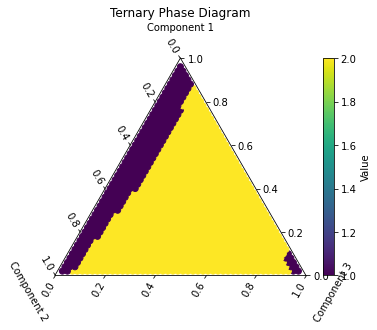

In [46]:
plot_ternary(ternary_matrix_2)

In [49]:
flattened_data = np.array([np.append(subarray, value) for subarray, value in ternary_matrix])
# Absolute path where the CSV file will be saved
name = 'ternary_0.02_chi_1.5_2.2_3.2.csv'
save_path = '/Users/calvinsmith/dufresne_lab/data/' + name  # Change this to your desired path

# Save to CSV
np.savetxt(save_path, flattened_data, delimiter=",", fmt='%g')
print('done')

done
